# 1.1 Build & evaluate an Emulator

Given a dynamical system $F: x_t \rightarrow x_{t_1} := F(x_t)$, we want to learn an emulator $G \approx F$ as a neural network from $F$-sampled trajectories.

Evaluate the quality of $G$ using:
- L2 or other error metric on 1-step updates
- L2 or other metric on longer rollouts
- Compare Lyapunov spectrum to original model
- Compare PSD etc. to original model
For each of these metrics, there are baselines one can compare to from the literature.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import L96sim

from L96_emulator.util import dtype, dtype_np, device

res_dir = '/gpfs/work/nonnenma/results/emulators/L96/'
data_dir = '/gpfs/work/nonnenma/data/emulators/L96/'

CUDA not available


### pick a (trained) emulator

In [2]:
from L96_emulator.run import setup

exp_id = 20

exp_names = os.listdir('experiments/')   
conf_exp = exp_names[np.where(np.array([name[:2] for name in exp_names])==str(exp_id))[0][0]][:-4]

args = setup(conf_exp=f'experiments/{conf_exp}.yml')
args.pop('conf_exp')

K,J = args['K'], args['J']

### load and instantiate the emulator model and an 'optimal' comparison available for L96

Updating julia wrappers, compilation might take a while....


/gpfs/home/nonnenma/projects/emulators/simulators/L96/L96sim/L96_base.py:236: UserWarning: Julia is not available, using slower python integrator. Per-seed results will change!!
  warnings.warn("Julia is not available, using slower python integrator. Per-seed results will change!!")


model output shape to test input of shape (10, 11, 36) torch.Size([10, 11, 36])
total #parameters:  1980


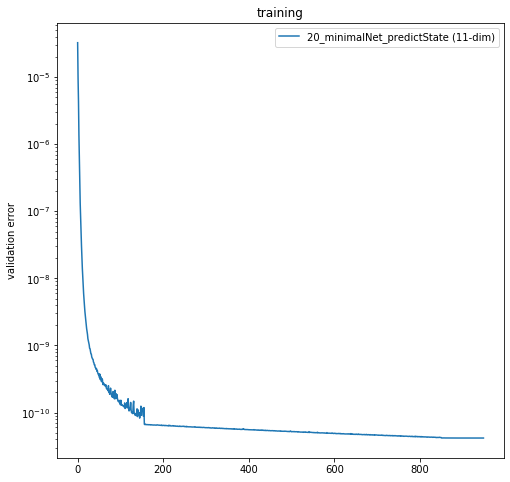

In [3]:
import torch 
import numpy as np
from L96_emulator.eval import load_model_from_exp_conf
from L96_emulator.networks import named_network


args['model_forwarder'] = 'rk4_default'
model, _, training_outputs = load_model_from_exp_conf(res_dir, args)

if not training_outputs is None:
    training_loss, validation_loss = training_outputs['training_loss'], training_outputs['validation_loss']

    fig = plt.figure(figsize=(8,8))
    seq_length = args['seq_length']
    plt.semilogy(validation_loss, label=conf_exp+ f' ({seq_length * (J+1)}-dim)')
    plt.title('training')
    plt.ylabel('validation error')
    plt.legend()
    fig.patch.set_facecolor('xkcd:white')
    plt.show()

# upper bound: model re-implementation of L96 in torch (conv1d->pointwise_square->conv1d)
model_ubo, model_forwarder_ubo =named_network(
        model_name='MinimalConvNetL96',
        n_input_channels=J+1,
        n_output_channels=J+1,
        seq_length=1,
        **{'filters': [0],
           'kernel_sizes': [4],
           'init_net': 'analytical',
           'K_net': K,
           'J_net': J,
           'dt_net': args['dt'],
           'model_forwarder': 'rk4_default'}
    )

# evaluate errors

In [4]:
from L96_emulator.eval import sortL96fromChannels, sortL96intoChannels
dX_dt = np.empty(K*(J+1), dtype=dtype_np)
T_start = np.array([50000, 100000, 15000]) # grab initial states for rollout from long-running simulations

### settings for different solvers

In [5]:
from L96_emulator.networks import Model_forwarder_predictorCorrector, Model_forwarder_rk4default

dts = {Model_forwarder_predictorCorrector : 0.001,
       Model_forwarder_rk4default : 0.01}

### load some data to get sensible test system state

In [6]:
from L96_emulator.run import sel_dataset_class

spin_up_time, train_frac = args['spin_up_time'], args['train_frac']
normalize_data = bool(args['normalize_data'])

T, dt = args['T'], args['dt']
fn_data = f'out_K{K}_J{J}_T{T}_dt0_{str(dt)[2:]}'
print('loading data')
out = np.load(data_dir + fn_data + '.npy')

prediction_task = 'state'
lead_time = 1
DatasetClass = sel_dataset_class(prediction_task=prediction_task)
dg_train = DatasetClass(data=out, J=J, offset=lead_time, normalize=normalize_data, 
                   start=int(spin_up_time/dt), 
                   end=int(np.floor(out.shape[0]*train_frac)))

loading data


### set up ground-truth simulator code

In [7]:
from L96sim.L96_base import f1, f2, pf2

F, h, b, c = 10., 1., 10., 10.

if J > 0:
    def fun(t, x):
        return f2(x, F, h, b, c, dX_dt, K, J)
else:
    def fun(t, x):
        return f1(x, F, dX_dt, K)

## direct error on rhs of diff.eq.

In [8]:
MSEs = np.zeros(len(T_start))
MSEs_ubo = np.zeros(len(T_start))

print('\n')
print('MSEs are on differential equation !')
print('\n')

for i in range(len(T_start)): # diff.eq. implementaion in numpy cannot necessarily handle parallel solving
    inputs = out[T_start[i]]
    inputs_torch = torch.as_tensor(sortL96intoChannels(np.atleast_2d(out[T_start[i]]),J=J),dtype=dtype,device=device)

    out_np = fun(0., inputs)
    out_model = model.forward(inputs_torch).detach().cpu().numpy()
    out_ubo = model_ubo.forward(inputs_torch).detach().cpu().numpy()
    
    MSEs[i] = ((out_np - sortL96fromChannels(out_model))**2).mean()
    MSEs_ubo[i] = ((out_np - sortL96fromChannels(out_ubo))**2).mean()

print('MSEs              ', MSEs)
print('MSEs - upper bound', MSEs_ubo)

print('\n')
print('MSEs (* dt)              ', MSEs*dt**2)
print('MSEs (* dt) - upper bound', MSEs_ubo*dt**2)




MSEs are on differential equation !


MSEs               [7.85630036e-05 4.04956736e-05 5.68968062e-05]
MSEs - upper bound [3.11071633e-12 1.72138356e-12 2.80836292e-12]


MSEs (* dt)               [7.85630036e-11 4.04956736e-11 5.68968062e-11]
MSEs (* dt) - upper bound [3.11071633e-18 1.72138356e-18 2.80836292e-18]


## 1-step integration error for different solvers

In [9]:
from L96_emulator.networks import Model_forwarder_predictorCorrector, Model_forwarder_rk4default
import torch 

print('\n')
print('MSEs are on system state !')
print('\n')

MSEs = np.zeros(len(T_start))
MSEs_ubo = np.zeros(len(T_start))

class Torch_solver(torch.nn.Module):
    # numerical solver (from numpy/numba/Julia)
    def __init__(self, fun):
        self.fun = fun
    def forward(self, x):
        x = sortL96fromChannels(x.detach().cpu().numpy()).flatten()
        return sortL96intoChannels(np.atleast_2d(fun(0., x)), J=J)

for MFWD in [Model_forwarder_predictorCorrector, Model_forwarder_rk4default]:
    model_forwarder_np = MFWD(Torch_solver(fun), 
                              dt=dts[MFWD])
    model_forwarder = MFWD(model=model, dt=dts[MFWD])
    model_forwarder_ubo = MFWD(model=model_ubo, dt=dts[MFWD])

    MSEs = np.zeros(len(T_start))
    for i in range(len(T_start)):
        inputs = out[T_start[i]]
        inputs_torch = torch.as_tensor(sortL96intoChannels(np.atleast_2d(out[T_start[i]]),J=J),
                                       dtype=dtype,device=device)

        out_np = model_forwarder_np(inputs_torch)
        out_model = model_forwarder(inputs_torch)
        out_ubo = model_forwarder_ubo(inputs_torch)

        MSEs[i] = ((out_np - out_model)**2).mean().detach().cpu().numpy()
        MSEs_ubo[i] = ((out_np - out_ubo)**2).mean().detach().cpu().numpy()

    print('\n')
    print(f'solver {MFWD}, dt = {dts[MFWD]}')
    print('\n')

    print('MSEs              ', MSEs)
    print('MSEs - upper bound', MSEs_ubo)




MSEs are on system state !




solver <class 'L96_emulator.networks.Model_forwarder_predictorCorrector'>, dt = 0.001


MSEs               [7.59632010e-11 4.01466811e-11 5.68893925e-11]
MSEs - upper bound [1.18933691e-17 4.88356416e-17 1.56097750e-17]


solver <class 'L96_emulator.networks.Model_forwarder_rk4default'>, dt = 0.01


MSEs               [5.27858202e-09 3.63223362e-09 5.84658499e-09]
MSEs - upper bound [1.41059795e-15 1.71079440e-16 1.61988606e-16]


## multi-step integration error (rollout error) for different solvers



MSEs are on system state !


solver <class 'L96_emulator.networks.Model_forwarder_predictorCorrector'>, dt = 0.001


/gpfs/home/nonnenma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


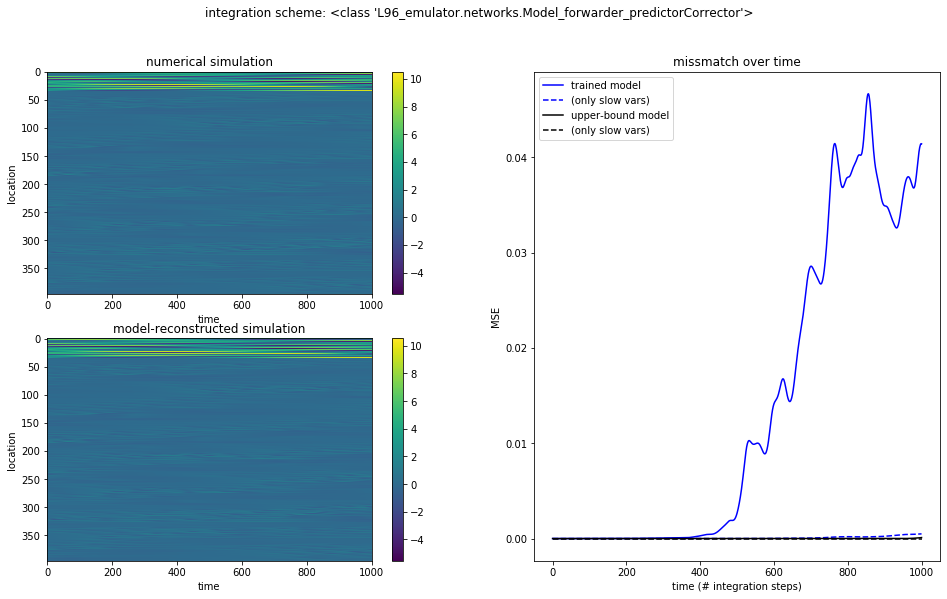

solver <class 'L96_emulator.networks.Model_forwarder_rk4default'>, dt = 0.01


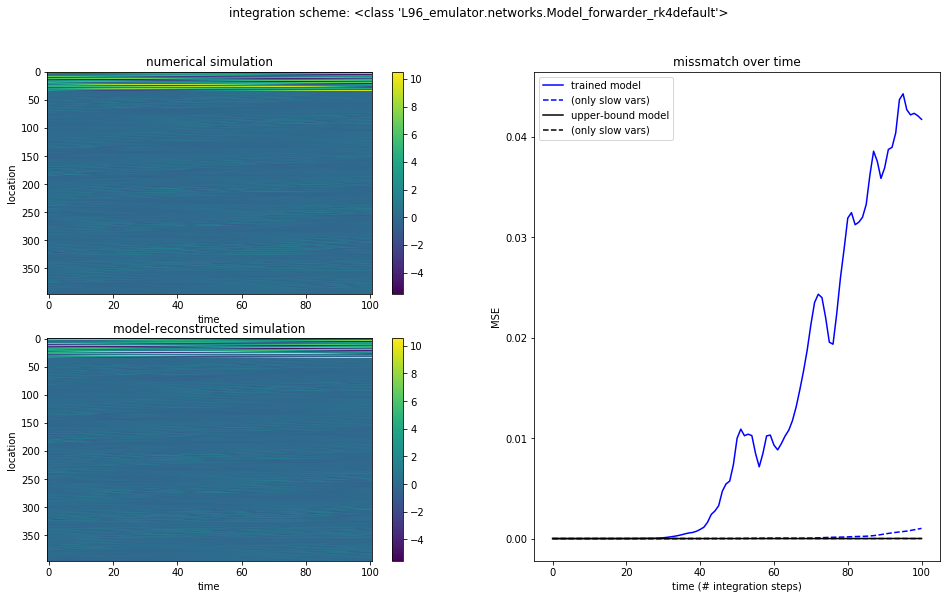

In [10]:
from L96_emulator.eval import get_rollout_fun, plot_rollout

print('\n')
print('MSEs are on system state !')
print('\n')


MTU = 1. # rollout time in time units, should be rough estimate of first Lyapunov exponent

i = 2 # pick one point to start rollout from


for MFWD in [Model_forwarder_predictorCorrector, Model_forwarder_rk4default]:
    
    print(f'solver {MFWD}, dt = {dts[MFWD]}')
    T_dur = int(MTU/dts[MFWD])
    
    model_forwarder_np = MFWD(Torch_solver(fun), 
                              dt=dts[MFWD])
    model_forwarder = MFWD(model=model, dt=dts[MFWD])
    model_forwarder_ubo = MFWD(model=model_ubo, dt=dts[MFWD])

    model_simulate = get_rollout_fun(dg_train, model_forwarder, prediction_task)
    ubo_simulate = get_rollout_fun(dg_train, model_forwarder_ubo, prediction_task)
    np_simulate = get_rollout_fun(dg_train, model_forwarder_np, prediction_task)
    
    out_np = np_simulate(y0=dg_train[T_start[i]].copy(), 
                         dy0=dg_train[T_start[i]]-dg_train[T_start-dg_train.offset],
                         n_steps=T_dur)
    out_np = sortL96fromChannels(out_np * dg_train.std + dg_train.mean)
    out_model = model_simulate(y0=dg_train[T_start[i]].copy(), 
                               dy0=dg_train[T_start[i]]-dg_train[T_start-dg_train.offset],
                               n_steps=T_dur)
    out_model = sortL96fromChannels(out_model * dg_train.std + dg_train.mean)

    out_ubo = ubo_simulate(y0=dg_train[T_start[i]].copy(), 
                               dy0=dg_train[T_start[i]]-dg_train[T_start-dg_train.offset],
                               n_steps=T_dur)
    out_ubo = sortL96fromChannels(out_ubo * dg_train.std + dg_train.mean)

    fig = plot_rollout(out_np, out_model, out_comparison=out_ubo, n_start=0, n_steps=T_dur, K=K)
    plt.subplot(1,2,2)
    plt.legend(['trained model', '(only slow vars)', 'upper-bound model', '(only slow vars)'])
    plt.suptitle('integration scheme: ' + str(MFWD))
    plt.show()


# tbd: compare Lyapunov spectrum

In [ ]:
# yeah, hf fiddling the pytorch model into Julia...

# tbd: check long-term stability

# tbd: compare distribution of values (PSD)

# share notebook results via html file

In [14]:
!jupyter nbconvert --output-dir='/gpfs/home/nonnenma/projects/lab_coord/mdml_wiki/marcel/emulators' --to html eval_emulator.ipynb
!cd /gpfs/home/nonnenma/projects/lab_coord/mdml_wiki/marcel/emulators
!git add eval_emulator.ipynb
!git commit -m "updating emulator notebook"

[NbConvertApp] Converting notebook eval_emulator.ipynb to html
[NbConvertApp] Writing 620304 bytes to /gpfs/home/nonnenma/projects/lab_coord/mdml_wiki/marcel/emulators/eval_emulator.html
